# Exercise 11 Part 2: Vision Transformers
**Summer Semester 2024**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

### Task: Implement & Train a ViT
Refer to the lecture and the original ViT paper (*AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE*, Dosovitskiy et al., 2020) for details. The naming of the hyperparameters is as in the aforementioned paper.

Similar to Part 1, you're expected to implement each block yourself, although you're allowed to use blocks like `torch.nn.MultiheadAttention`, `torch.nn.Linear`, etc. Implement the blocks as in the original ViT paper. No usage of things such as full pre-made FFN/self-attention blocks or full transformer implementations like `torchvision.models.vision_transformer.VisionTransformer` is allowed for this exercise. You're expected to do full vectorized implementations in native PyTorch (again, einops is allowed) without relying on Python for loops for things such as patching etc.

Some relevant details:
- For simplicity of implementation, we will use a randomly (Gaussian with mean 0 and variance 1) initialized *learnable* positional embedding, not a Fourier/sinusoidal one.
- Don't forget about all of the layer norms!
- Consider the `batch_first` attribute of `nn.MultiheadAttention`, should you use that class
- We'll make the standard assumption that $\mathrm{dim}_\text{head} = \mathrm{dim}_\text{hidden} / N_\text{heads}$

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}".')

Using device "mps".


In [3]:
class ResidualModule(nn.Module):
    def __init__(self, inner_module: nn.Module):
        super().__init__()
        self.inner_module = inner_module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.inner_module(x)


class FeedForwardBlock(nn.Module):
    # Student (1P)
    # Tip: Dropout goes after each linear layer in the feedforward block
    def __init__(self, dim_hidden, mlp_dim, p_dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_hidden, mlp_dim),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(mlp_dim, dim_hidden),
            nn.Dropout(p_dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class SelfAttentionTransformerBlock(nn.Module):
    # Student (2P)
    # Should contain one self-attention block and use a FeedForwardBlock instance for the mlp
    def __init__(self, dim_hidden, n_heads, mlp_dim, p_dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim_hidden)
        self.attn = nn.MultiheadAttention(
            dim_hidden, n_heads, dropout=p_dropout, batch_first=True
        )
        self.ln2 = nn.LayerNorm(dim_hidden)
        self.ffn = FeedForwardBlock(dim_hidden, mlp_dim, p_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x), need_weights=False)[0]
        x = x + self.ffn(self.ln2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        patch_size: int = 4,
        image_size: int = 32,
        layers: int = 6,
        hidden_size: int = 256,
        mlp_size: int = 512,
        n_heads: int = 8,
        num_classes: int = 10,
        p_dropout: float = 0.2,
    ):
        super().__init__()

        # Student (2P)
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.hidden_size = hidden_size

        # Learnable linear projection for patches
        self.patch_to_embedding = nn.Linear(
            in_channels * patch_size * patch_size, hidden_size
        )

        # Learnable positional embeddings
        self.positional_embeddings = nn.Parameter(
            torch.randn(1, self.num_patches + 1, hidden_size)
        )

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))

        # Dropout
        self.dropout = nn.Dropout(p_dropout)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList(
            [
                SelfAttentionTransformerBlock(hidden_size, n_heads, mlp_size, p_dropout)
                for _ in range(layers)
            ]
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_size), nn.Linear(hidden_size, num_classes)
        )

    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        """Takes an image tensor of shape (B, C, H, W) and transforms it to a sequence of patches (B, L, D), with a learnable linear projection after flattening,
        and a standard additive positional encoding applied. Note that the activations in (Vision) Transformer implementations are
        typically passed around in channels-_last_ layout, different from typical PyTorch norms.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Embedded patch sequence tensor with positional encodings applied and shape (B, L, D)
        """
        # Student (2P)
        B, C, _, _ = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(
            3, self.patch_size, self.patch_size
        )
        patches = patches.contiguous().view(B, C, -1, self.patch_size * self.patch_size)
        patches = (
            patches.permute(0, 2, 1, 3)
            .contiguous()
            .view(B, -1, self.patch_size * self.patch_size * C)
        )
        return patches

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Takes an image tensor of shape (B, C, H, W), applies patching, a standard ViT and then an output projection of the CLS token
        to finally create a class logit prediction of shape (B, N_cls)

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, N_cls)
        """
        # Student (1P)
        B, _, _, _ = x.shape
        x = self.patchify(x)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.positional_embeddings
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        cls_output = x[:, 0]
        return self.mlp_head(cls_output)

### Training
Do not modify this code!
You are free to modify the four parameters in the first block, although no modifications should be necessary to achieve >70% validation accuracy with a correct transformer implementation.

In [2]:
DATASET_CACHE_DIR = './data'
BATCH_SIZE = 128
LR = 3e-4
N_EPOCHS = 50

100%|██████████| 170498071/170498071 [00:26<00:00, 6358297.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Training (Epoch 1/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.443


Training (Epoch 2/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.518


Training (Epoch 3/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.541


Training (Epoch 4/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.557


Training (Epoch 5/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.572


Training (Epoch 6/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.593


Training (Epoch 7/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.596


Training (Epoch 8/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.606


Training (Epoch 9/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.603


Training (Epoch 10/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.618


Training (Epoch 11/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.636


Training (Epoch 12/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.631


Training (Epoch 13/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.629


Training (Epoch 14/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.641


Training (Epoch 15/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.651


Training (Epoch 16/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.654


Training (Epoch 17/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.647


Training (Epoch 18/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.660


Training (Epoch 19/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.669


Training (Epoch 20/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.668


Training (Epoch 21/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.673


Training (Epoch 22/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.675


Training (Epoch 23/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.665


Training (Epoch 24/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.682


Training (Epoch 25/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.691


Training (Epoch 26/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.685


Training (Epoch 27/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.699


Training (Epoch 28/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.694


Training (Epoch 29/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.699


Training (Epoch 30/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.703


Training (Epoch 31/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.701


Training (Epoch 32/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.700


Training (Epoch 33/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.710


Training (Epoch 34/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.703


Training (Epoch 35/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.700


Training (Epoch 36/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.715


Training (Epoch 37/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.707


Training (Epoch 38/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.708


Training (Epoch 39/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.712


Training (Epoch 40/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.719


Training (Epoch 41/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.715


Training (Epoch 42/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.711


Training (Epoch 43/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.717


Training (Epoch 44/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.721


Training (Epoch 45/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.714


Training (Epoch 46/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.713


Training (Epoch 47/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.713


Training (Epoch 48/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.719


Training (Epoch 49/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.727


Training (Epoch 50/50): 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy: 0.718


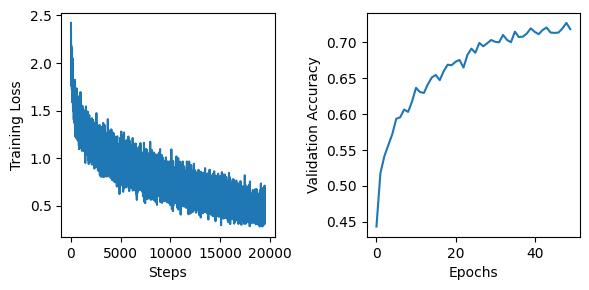

In [4]:
transforms_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])
transforms_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

model = VisionTransformer().to(device)
optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

dataloader_train = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=True, download=True, transform=transforms_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
dataloader_val = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=False, download=True, transform=transforms_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

train_losses = []
val_accs = []

for i_epoch in range(N_EPOCHS):
    for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_train), desc=f'Training (Epoch {i_epoch + 1}/{N_EPOCHS})')):
        optim.zero_grad()
        loss = loss_fn(model(images.to(device)), labels.to(device))
        loss.backward()
        optim.step()

        # Some logging
        loss_val = loss.detach().item()
        train_losses.append(loss_val)
        pbar.set_postfix({ 'loss': loss_val } | ({ 'val_acc': val_accs[-1] } if len(val_accs) > 0 else { }))
    
    # Validation every epoch
    with torch.no_grad():
        n_total, n_correct = 0, 0
        for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_val), desc='Validating')):
            predicted = model(images.to(device)).argmax(dim=-1)
            n_correct += (predicted.cpu() == labels).float().sum().item()
            n_total += labels.shape[0]
        val_accs.append(n_correct / n_total)
        print(f'Validation accuracy: {val_accs[-1]:.3f}')

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(train_losses)
plt.xlabel('Steps') 
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()